<a href="https://colab.research.google.com/github/Sugi1999/Computational-Biology-Projects/blob/main/Model_Fitting_and_Cross_Validation_with_BioModel_45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions

In this homework, you will do a cross validation for
BioModels model 45. Although the model has a large number of parameters, we will only consider ``beta``.


1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.
   1. (10 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (60 pts) **Experiment Implementation**. Implement codes that do cross validation. It should input the number of folds (possibly
with other arguments); a DataFrame with rows for the model and for beta and columns
for the mean, standard deviation, lower end of the 90 percent confidence interval,
and upper end of this confidence interval.
You should have codes for:

   1. (30 pts) ``crossValidate`` - overall workflow for doing cross validation
      * Inputs: model (str), observedData (matrix), parameterNames (list-str)
      * Outputs: DataFrame as described above
   1. (15 pts) ``calcRsq``
      * Inputs: predicted values (matrix), observed values (marix)
      * Ouputs: float
   1. (15 pts) ``reportResults``
      * Inputs: $R^2$ values (list-float), parameter estimates (list-dict)
      * Outputs: DataFrame with mean, stadard deviation, and 90% confidence interval for model and parameters
   
   Feel free to make use of the codes from class and/or the codes in the "Helpers" section.
   As always, you should abide by the rules for writing software.
   
1. (20 pts) **Experiment Execution and Analysis**. Do a 3, 5, and 10 fold cross validation using alternating folds for the 3 datasets. That is, fold 1 has the points 1, 11, 21, ..;
fold 2 has the points 2, 12, 22, ...; and so on. 
   1. (5 pts) Construct heatmaps for the standard deviation of model $R^2$ and the standard deviation of ``beta`` where the horizontal axis is standard deviation of noise in observed data and the vertical axis
   is the number of folds.
   1. (5 pts) For $R^2$, how is variability affected
by the number of folds? How is variability affected by the variability of the training data?
   1. (5 pts) For ``beta``, how is variability affected
by the number of folds? How is variability affected by the variability of the training data?
   1. (5 pts) Based on your answers to the last two questions, how many folds would you use to evaluate model quality and assess the quality of parameter estimates? What's another reason for your choice of the number of folds?
   
1. (10 pt) **Extra credit.** How would you frame the analysis in (3) using the language of design of experiments.

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
try:
    import SBstoat
except:
    !pip install -q SBstoat
    import SBstoat


     |████████████████████████████████| 28.1 MB 56.6 MB/s 
     |████████████████████████████████| 292 kB 43.6 MB/s 
     |████████████████████████████████| 154 kB 53.1 MB/s 
     |████████████████████████████████| 98 kB 7.5 MB/s 


## Constants

In [ ]:
ENDTIME = 60
NUMPOINT = 1200
STDS = [0.1, 0.2, 0.5]
NUMFOLDS = [3, 5, 10]
# Column names
C_TIME = "time"
#

## BioModels 45

In [ ]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.12.0
model *Goldbeter_Calcium_Oscillation_based_onCICR_AND_two_pool_model()

  // Compartments and Species:
  compartment extracellular, cytosol, intravesicular1, intravesicular2;
  species EC in extracellular, Z in cytosol, Y in intravesicular2, X in intravesicular1;

  // Reactions:
  vin: EC => Z; cytosol*(vin_v0 + vin_v1*beta);
  v2i: Z => Y; intravesicular2*v2i_Vm2i*Z^2/(v2i_K2i^2 + Z^2);
  v3i: Y => Z; cytosol*v3i_Vm3i*Y^2*Z^2/((v3i_K3y^2 + Y^2)*(v3i_K3z^2 + Z^2));
  v4: Y => Z; cytosol*v4_Kf*Y;
  v5: Z => EC; extracellular*v5_K*Z;
  v6: X => Z; cytosol*v6_Kf*X;
  v2s: Z => X; intravesicular1*v2s_Vm2s*Z^2/(v2s_K2s^2 + Z^2);
  v3s: X => Z; cytosol*beta*v3s_Vm3s*X^2/(v3s_K3s^2 + X^2);

  // Species initializations:
  EC = 0;
  Z = 0;
  Y = 0;
  X = 0.5;

  // Compartment initializations:
  extracellular = 1;
  cytosol = 1;
  intravesicular1 = 1;
  intravesicular2 = 1;

  // Variable initializations:
  beta = 1;
  vin_v0 = 0.015;
  vin_v1 = 0.012;
  v2i_

In [ ]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index(C_TIME)
    return df

# Tests
assert(isinstance(arrToDF(MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


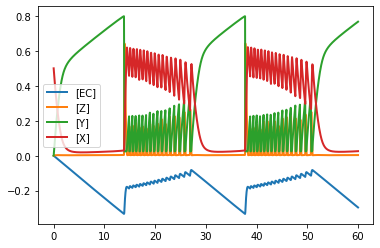

In [ ]:
# Values of model parameters in the model
MODEL_RR.reset()
MODEL_ARR = MODEL_RR.simulate(0, 60, 1200)
MODEL_RR.plot(MODEL_ARR)
MODEL_DF = arrToDF(MODEL_ARR)

## Helper Functions

In [ ]:
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = list(set(indices).difference(testIndices))
        yield trainIndices, testIndices
        
# Tests
numpoint = 6
numfold = 3
generator = foldGenerator(numpoint, numfold)
folds = list(generator)
assert(len(folds) == numfold)
for fold in folds:
    composite = list(fold[0])
    composite.extend(fold[1])
    assert(len(composite) == numpoint)
print("OK!")

OK!


In [ ]:
def findCloseMatchingValues(longArr, shortArr):
    """
    Finds the indices in longArr that are closest to the values in shortArr.

    Parameters
    ----------
    longArr: np.array
    shortArr: np.arry

    Returns
    -------
    array-int
    """
    indices = []
    for val in shortArr:
        distances = (longArr - val)**2
        minDistance = np.min(distances)
        distancesLst = list(distances)
        idx = distancesLst.index(minDistance)
        indices.append(idx)
    return np.array(indices)

# TESTS
longArr = np.array(range(10))
shortArr = np.array([2.1, 2.9, 4.3])
indexArr = findCloseMatchingValues(longArr, shortArr)
expectedArr = [2, 3, 4]
assert(all([v1 == v2 for v1, v2 in zip(indexArr, expectedArr)]))
print("OK!")


OK!


In [ ]:
def makeSyntheticData(df, std):
    """
    Creates synthetic data by adding a normally distributed random variable with mean zero and the specified
    standard deviation.
    
    Parameters
    ----------
    df: DataFrame
    std: float
    
    Returns
    -------
    DataFrame with same index and column names as df
    """
    timeseries = SBstoat.NamedTimeseries(dataframe=df)
    synthesizer = SBstoat.ObservationSynthesizerRandomErrors(fittedTS=timeseries, std=std)
    syntheticTS = synthesizer.calculate()
    df =  syntheticTS.to_dataframe()
    return df

#TESTS
observedDF = makeSyntheticData(MODEL_DF, 0)
assert(observedDF.equals(MODEL_DF))
print("OK!")

OK!


In [ ]:
def fitModel(model, observedDF, parameterNames, testIdxs):
    """
    Fits the model parameters to the observed data.
    
    Parameters
    ----------
    model: str
        Antimony model or roadrunner
    observedDF: DataFrame
        Index: time
        Columns: floating species
    parameterNames: list-str
    testIdxs: list-int
        Indices in data that should be ignored in fitting since
        they will be used to evaluate test data
    
    Returns
    -------
    parameterDct
        key: parameterName
        value: parameterEstimate
    DataFrame - fitted values
        key: time
        columns: floating species     
    """
    indexArr = np.array(observedDF.index)
    endTime = max(observedDF.index)
    testIndices = indexArr[testIdxs]  # Elements in index that are test data
    newObservedDF = observedDF.copy()
    newObservedDF.loc[testIndices, :] = np.nan
    newObservedDF.index.name = C_TIME
    observedTS = SBstoat.NamedTimeseries(dataframe=newObservedDF)
    fitter = SBstoat.ModelFitter(model, observedTS,
                          parameterNames,
                          endTime=endTime,
                          numPoint=len(observedDF))
    fitter.fitModel()
    parameterDct = dict(fitter.params.valuesdict())
    #
    return parameterDct, fitter.fittedTS.to_dataframe()

# Tests
observedDF = makeSyntheticData(MODEL_DF, 0)
observedDF = observedDF[observedDF.index < 5]
parameterDct, fittedDF = fitModel(MODEL_ANT, observedDF, ["beta"], [10, 20])
assert(len(parameterDct) == 1)
assert(np.abs(parameterDct["beta"] - 1) < 0.001)
assert(len(observedDF) == len(fittedDF))
print("OK!")

OK!


In [ ]:
# def runSimulation(simTime=ENDTIME, numPoint=NUMPOINT, roadRunner=None,
#                   parameterDct=None, model=MODEL_ANT):
#     """
#     Runs the simulation model for the parameters.
   
#     Parameters
#     ----------
#     endTime: float
#         End time for the simulation
#     numPoints: int
#         Number of points in the simulation
#     roadRunner: ExtendedRoadRunner
#     parameters: list-str
        
#     Returns
#     -------
#     NamedArray
#         results of simulation
#     """
#     if roadRunner is None:
#         roadRunner = te.loada(model)
#     else:
#         roadRunner.reset()
#     if parameterDct is not None:
#         # Set the simulation constants for all parameters
#         for name in parameterDct.keys():
#             roadRunner[name] = parameterDct[name]
#     return roadRunner.simulate (0, simTime, numPoint)

# # TESTS
# numPoint = int(10*ENDTIME)
# fittedData = runSimulation(parameterDct={"beta": 0.1}, numPoint=numPoint)
# numCol = np.shape(fittedData)[1]
# assert(np.size(fittedData) == numPoint*numCol)


# Question 1: Data Generation

In [ ]:
#1.1
#Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.

sd_01 = makeSyntheticData(MODEL_DF, 0.1)
sd_02 = makeSyntheticData(MODEL_DF, 0.2)
sd_05 = makeSyntheticData(MODEL_DF, 0.5)


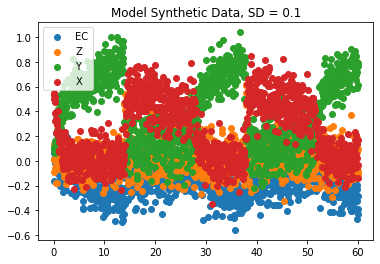

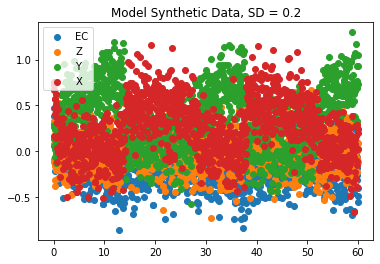

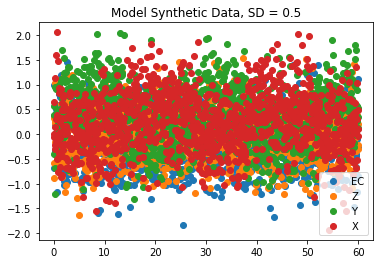

In [ ]:
#1.2
#Plot the three datatsets. What characteristics of the data confirm that these synthetic data are consistent with your expectations.
x = np.linspace(0, ENDTIME, NUMPOINT)
plt.scatter(x, sd_01['EC'])
plt.scatter(x, sd_01['Z'])
plt.scatter(x, sd_01['Y'])
plt.scatter(x, sd_01['X'])
plt.title('Model Synthetic Data, SD = 0.1')
plt.legend(['EC', 'Z', 'Y', 'X'])
plt.show()

plt.scatter(x, sd_02['EC'])
plt.scatter(x, sd_02['Z'])
plt.scatter(x, sd_02['Y'])
plt.scatter(x, sd_02['X'])
plt.title('Model Synthetic Data, SD = 0.2')
plt.legend(['EC', 'Z', 'Y', 'X'])
plt.show()

plt.scatter(x, sd_05['EC'])
plt.scatter(x, sd_05['Z'])
plt.scatter(x, sd_05['Y'])
plt.scatter(x, sd_05['X'])
plt.title('Model Synthetic Data, SD = 0.5')
plt.legend(['EC', 'Z', 'Y', 'X'])
plt.show()

assert(len(x)==len(MODEL_DF))

This synthetic data is consistent with my expectations. As we add more standard deviation the data is more random and strays further from the shape we see in our experimental model. 

# Question 2: Experiment Implementation

In [ ]:
def calcRsq(fittedDF, testData, model=MODEL_RR):
  '''
  takes an estimated paramater value (from train), testdata, and model. 
  finds the rsq of the model

  Parameters
  ----------
  parameterEstimates - dict:
                       key - parameter (string)
                       value - value of parameter
  testData - dataframe of test data only
  model - antimony model loaded 

  Returns
  -------
  Rsq - rsquared value (float)

  '''
  indicies = findCloseMatchingValues(fittedDF.index, testData.index)
  indicies = [list(fittedDF.index)[x] for x in indicies]
  fittedDF=fittedDF.loc[indicies,:]
  columns = fittedDF.columns

  #calculating rsq
  fit_val = []
  test_val = []
  for col in columns:
    fit_val.extend(list(fittedDF.loc[:, col]))
    test_val.extend(list(testData.loc[:, col]))
  
  res = [t_val - f_val for t_val, f_val in zip(test_val, fit_val)]
  rsq = 1 - np.var(res) / np.var(test_val)
  return rsq
 



# TESTS
# inputs
model = MODEL_ANT
observedData = MODEL_DF
parameterNames = ['beta']
folds = list(foldGenerator(6, 2))
testIndicies = folds[0][1]

#perform fit
parameterEstimates, fitDF = fitModel(model, observedData, parameterNames, testIndicies)
#calculate rsq
obTime = observedData.index
testIndicies = [obTime[x] for x in testIndicies]
testData = observedData.loc[testIndicies,:]
rsq = calcRsq(fitDF, testData)
#make sure rsq is larger than 0
assert(rsq>0)
assert(type(rsq)==np.float64)

In [ ]:
def reportResults(rsq_data, parameterEstimates, numfold=3, dataname='test'):
  '''
  calculates the mean, std, and CI levels for beta and rsq

  Parameters
  ----------
  rsq_data - list of rsq values from folds
  parameterEstimates - dict of key: parameter value: parameter value
  numfold - number of folds int
  dataname - str of the model name (numfold+syntheticdata std) ex. 3std=0.1

  Returns
  -------
  cv_df - a dataframe with rows as model name, 
          columns: beta mean, beta std, beta CI lower, beta CI higher, 
          rsq mean, rsq std, rsq CI lower, rsq CI higher, std of data, num folds
  '''
  print(parameterEstimates)
  #get means
  betas = [x['beta'] for x in parameterEstimates]
  beta_mean = np.mean(betas)
  rsq_mean = np.mean(rsq_data)

  #standard deviations
  beta_std = np.std(betas)
  rsq_std = np.std(rsq_data)

  #CI
  CI_rsq = st.t.interval(alpha=0.9, df=len(rsq_data)-1, loc=np.mean(rsq_data), scale=st.sem(rsq_data))
  CI_beta = st.t.interval(alpha=0.9, df=len(betas)-1, loc=np.mean(betas), scale=st.sem(betas))

  #build data frame
  cv_df = {'beta mean':beta_mean, 'beta std':beta_std,
           'CI beta lower':CI_beta[0], 'CI beta higher':CI_beta[1],
           'rsq mean':rsq_mean, 'rsq std':rsq_std,
           'CI rsq lower':CI_rsq[0], 'CI rsq higher':CI_rsq[1]}
  cv_df = pd.DataFrame(cv_df, index=[(str(numfold)+' fold, '+dataname)])

  return cv_df


# TESTS
# inputs
model = MODEL_ANT
observedData = MODEL_DF
parameterNames = ['beta']
folds = list(foldGenerator(6, 2))

parameterEstimatesCollection = []
rsq_data = []
for fold in folds:
  testIndicies = fold[1]

  # perform fit
  parameterEstimates, fitDF = fitModel(model, observedData, parameterNames, testIndicies)
  # calculate rsq
  obTime = observedData.index
  testIndicies = [obTime[x] for x in testIndicies]
  testData = observedData.loc[testIndicies,:]
  rsq = calcRsq(fitDF, testData)

  # make lists
  parameterEstimatesCollection.append(parameterEstimates)
  rsq_data.append(rsq)

# run report
cv_df = reportResults(rsq_data, parameterEstimatesCollection, numfold)
#make sure there are no std's that are less than 0
series = cv_df['beta std'][cv_df['beta std'] < 0]
assert(len(series)==0)
#make sure there are no std's that are less than 0
series = cv_df['rsq std'][cv_df['rsq std'] < 0]
assert(len(series)==0)

[{'beta': 1.0000000530156763}, {'beta': 1.0000000163341467}]


In [ ]:
def crossValidate(model, observedData, parameterNames, numfold=3, dataname='test'):
  '''
  Cross validates a model by breaking in to training and test data sets. Returns
  a dataframe of beta and rsq analysis. 

  Parameters
  ----------
  model - model string
  observedData - matrix
  parameterNames - list of strings
  numfold - int num of folds
  dataname - str of the model name (numfold+syntheticdata std) ex. 3std=0.1

  Returns
  -------
  cv_df - a dataframe with rows as model name, 
          columns: beta mean, beta std, beta CI lower, beta CI higher, 
          rsq mean, rsq std, rsq CI lower, rsq CI higher, std of data, num folds
  '''
  #CHANGE 6 TO NUMPOINT
  folds = list(foldGenerator(NUMPOINT, numfold))
  parameterEstimatesCollection = []
  rsq_data = []
  for fold in folds:
    testIndicies = fold[1]
    #perform fit
    parameterEstimates, fitDF = fitModel(model, observedData, parameterNames, testIndicies)
    #calculate rsq
    obTime = observedData.index
    testIndicies = [obTime[x] for x in testIndicies]
    testData = observedData.loc[testIndicies,:]
    rsq = calcRsq(fitDF, testData)
    #append values
    parameterEstimatesCollection.append(parameterEstimates)
    rsq_data.append(rsq)
  cv_df = reportResults(rsq_data, parameterEstimatesCollection, numfold, dataname=dataname)
  return cv_df


# TESTS
test_df = crossValidate(MODEL_ANT, MODEL_DF, ['beta'])
assert(type(test_df)==pd.core.frame.DataFrame)
#make sure there are no std's that are less than 0
series = test_df['beta std'][test_df['beta std'] < 0]
assert(len(series)==0)
#make sure there are no std's that are less than 0
series = test_df['rsq std'][test_df['rsq std'] < 0]
assert(len(series)==0)

[{'beta': 1.000001263565552}, {'beta': 1.0000002545078222}, {'beta': 1.000000885167665}]


# Question 3: Experiment Execution and Analysis

[{'beta': 0.9999899624617329}, {'beta': 1.0000086014008474}, {'beta': 1.000028699432186}]
[{'beta': 1.0000173848430165}, {'beta': 1.000060480958662}, {'beta': 1.000069779434237}]
[{'beta': 0.9999319489853683}, {'beta': 0.999804047175287}, {'beta': 0.9996791286260239}]
[{'beta': 1.000038595572977}, {'beta': 1.0000201241541211}, {'beta': 1.000003814708414}, {'beta': 1.00000890748998}, {'beta': 0.9999828584085352}]
[{'beta': 1.0000376596466178}, {'beta': 1.0000347227784774}, {'beta': 1.0000516602854888}, {'beta': 1.0000383725070479}, {'beta': 1.000033134196809}]
[{'beta': 0.9998919135307806}, {'beta': 0.9999436717135125}, {'beta': 0.9999449721327006}, {'beta': 0.9999452199036828}, {'beta': 0.9995785641921723}]
[{'beta': 0.999998229385825}, {'beta': 1.0000032734498672}, {'beta': 1.0000110710056225}, {'beta': 1.000007754761273}, {'beta': 0.9999786200598749}, {'beta': 1.0000094862550029}, {'beta': 1.000011479151109}, {'beta': 1.0000072719416373}, {'beta': 1.0000008632036057}, {'beta': 1.0000

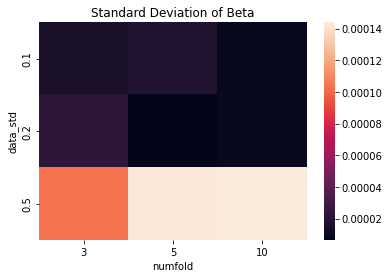

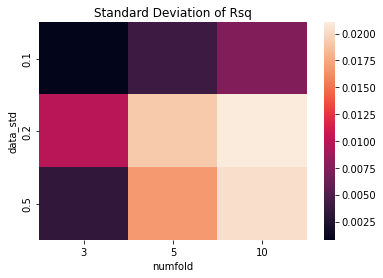

,beta mean,beta std,CI beta lower,CI beta higher,rsq mean,rsq std,CI rsq lower,CI rsq higher,data_std,numfold
"3 fold, std=0.1",1.000009,0.000016,0.999976,1.000042,0.887623,0.000798,0.885976,0.889271,0.1,3
"3 fold, std=0.2",1.000049,0.000023,1.000002,1.000096,0.669999,0.010001,0.649348,0.690649,0.2,3
"3 fold, std=0.5",0.999805,0.000103,0.999592,1.000018,0.239594,0.003463,0.232445,0.246744,0.5,3
"5 fold, std=0.1",1.000011,0.000018,0.999991,1.000030,0.887673,0.003996,0.883414,0.891933,0.1,5
"5 fold, std=0.2",1.000039,0.000007,1.000032,1.000046,0.669580,0.019283,0.649025,0.690134,0.2,5
"5 fold, std=0.5",0.999861,0.000143,0.999709,1.000013,0.240756,0.016811,0.222837,0.258676,0.5,5
"10 fold, std=0.1",1.000003,0.000009,0.999998,1.000009,0.887611,0.007423,0.883075,0.892146,0.1,10
"10 fold, std=0.2",1.000045,0.000009,1.000040,1.000051,0.669582,0.021037,0.656727,0.682436,0.2,10
"10 fold, std=0.5",0.999858,0.000144,0.999770,0.999946,0.240629,0.020379,0.228177,0.253081,0.5,10


In [ ]:
def runExperiment(numfold, data_set):
  '''
  calls crossvalidates for all numfold+data set combinations.
  prints heatmaps for beta std and rsq std with axis data std and num folds

  Parameters
  ----------
  numfold - number of folds list of ints
  data_set - list of synthetic data sets

  Returns
  -------
  exp_df - dataframe of analysis of beta and rsq for each numfold+dataset comb
          rows - numfold+dataset str comb
          columns - beta mean, beta std, beta CI lower, beta CI higher, 
          rsq mean, rsq std, rsq CI lower, rsq CI higher, std of data, num folds
  '''
  cv_dfs = []
  data_std = []
  num_fold = []
  for num in numfold:
    for data in data_set:
      cv_dfs.append(crossValidate(MODEL_ANT, data[0], ['beta'], numfold=num, dataname=data[1]))
      data_std.append(data[1][-3:])
      num_fold.append(num)

  experiments = pd.concat(cv_dfs)
  experiments['data_std'] = data_std
  experiments['numfold'] = num_fold

  pivot_beta = experiments.pivot('data_std', 'numfold', 'beta std')
  #ax = sns.heatmap(pivot_data, square=True, norm=LogNorm())
  axb = sns.heatmap(pivot_beta)
  axb.set_title('Standard Deviation of Beta')
  plt.show()
  
  pivot_rsq = experiments.pivot('data_std', 'numfold', 'rsq std')
  #ax = sns.heatmap(pivot_data, square=True, norm=LogNorm())
  axr = sns.heatmap(pivot_rsq)
  axr.set_title('Standard Deviation of Rsq')
  plt.show()
  
  return experiments
  
  
# TESTS

data_set = [(sd_01,'std=0.1'), (sd_02, 'std=0.2'), (sd_05, 'std=0.5')]
numfold = [3, 5, 10]
exp_df = runExperiment(numfold, data_set)
display(exp_df)

assert(exp_df.index.size==(len(numfold)*len(data_set)))
assert(type(exp_df)==pd.core.frame.DataFrame)
#make sure there are no std's that are less than 0
series = exp_df['beta std'][exp_df['beta std'] < 0]
assert(len(series)==0)
#make sure there are no std's that are less than 0
series = exp_df['rsq std'][exp_df['rsq std'] < 0]
assert(len(series)==0)


3.2

The variability of $R^2$ increases with the number of folds. 

The variability of $R^2$ increases with increasing std in the synthetic data.

3.3

The variability of beta seems constant across the number of folds and the standard deviation in the data. Except a outlier where number of folds is 5 and std of synthetic data is 0.2, the std of beta jumps up x6 it's neighbors. Running it again, the outlier shifted to number of folds = 10, std of data = 0.2. I don't think we should base our analysis on this statistic. 



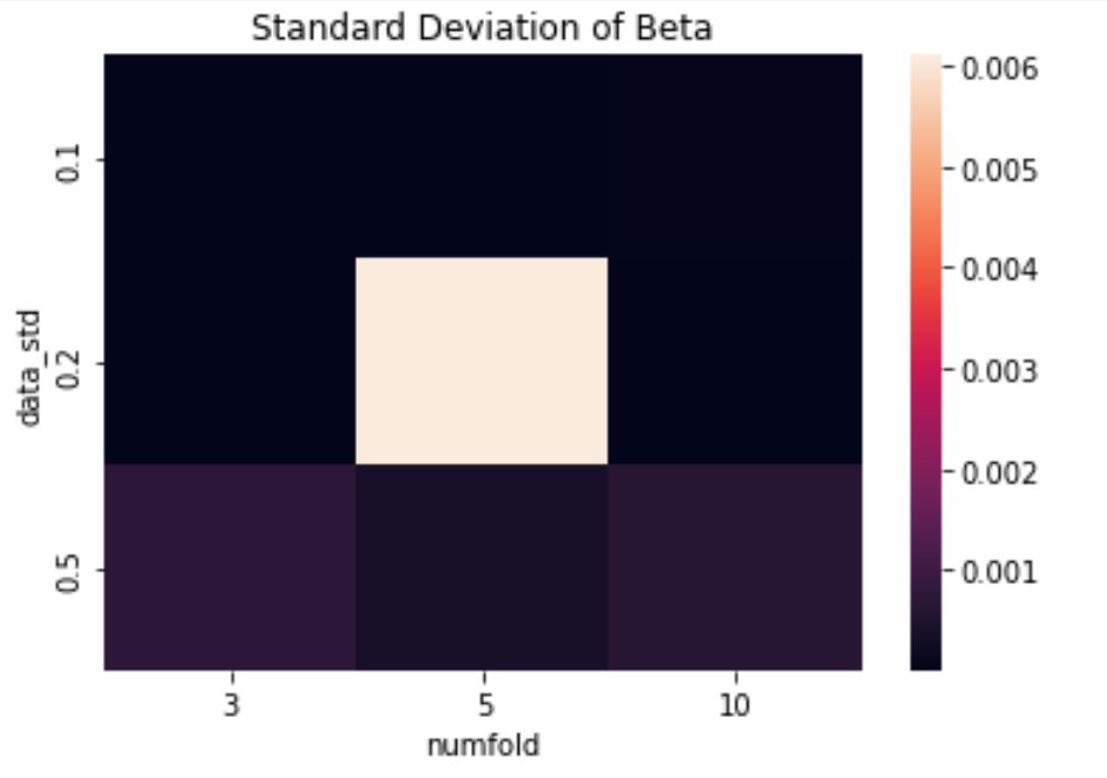
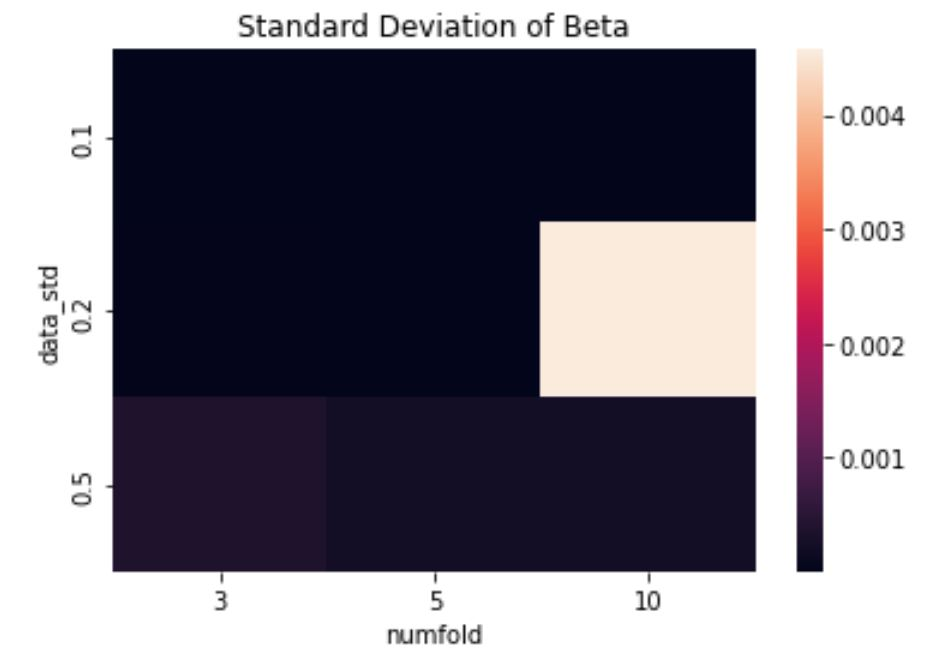

3.4 

Based off my previous answers I would use a smaller number of folds. the std of beta doesn't seem to be a reliable measurement of quality. Therefore, going off of std in rsq, I would use a smaller number of folds as that consistently reduces std in $R^2$. 

Using less folds also means fewer sets of training and test data, which makes it faster. A desireable quality. 

##Question 4: Extra Credit


4.1 

As a DOE I would frame our analysis with parameters: number of folds, variation of data set. Each parameter has 3 levels. Number of folds: {3 folds, 5 folds, 10 folds}. Variation of data set: {0.1 std, 0.2 std, 0.5 std}. This could be intererperted as -1, 0 (baseline), 1, levels. 

We had two measured outputs, $R^2$ variability and beta variability. I would optimize for $R^2$ as it seems to be more predictable. If optimizing for $R^2$ variability I would have found number of folds = 3, and std in data = 0.1, combination to be the best.